# Matrix Factorization (MF) part 2: Getting Fancy
Demonstrates matrix factorization with MXNet on the [MovieLens 100k](http://grouplens.org/datasets/movielens/100k/) dataset.  This is an extension of [part 1](demo1-MF.ipynb) where we try fancy optimizers and network structures.


In [47]:
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon

from matrix_fact import train
from movielens_data import get_dataset, max_id

In [2]:
ctx = mx.gpu() if len(mx.test_utils.list_gpus()) > 0 else mx.cpu()
batch_size = 50

## Data

In [3]:
train_dataset, test_dataset = get_dataset()
max_user, max_item = max_id('./ml-100k/u.data')
(max_user, max_item)

(944, 1683)

In [4]:
train_data = gluon.data.DataLoader(train_dataset, shuffle=True, last_batch='rollover', batch_size=batch_size, num_workers=0)
test_data = gluon.data.DataLoader(test_dataset, shuffle=True, last_batch='rollover', batch_size=batch_size, num_workers=0)

In [5]:
for user, item, score in test_data:
    print(user[0], item[0], score[0])
    break


[85.]
<NDArray 1 @cpu(0)> 
[1101.]
<NDArray 1 @cpu(0)> 
[4.]
<NDArray 1 @cpu(0)>


## Linear MF
Same as before, but this time with the [Adam optimizer](https://arxiv.org/abs/1412.6980) which will often converge much faster than SGD without momentum as we used before.  You should see this model over-fitting quickly. 

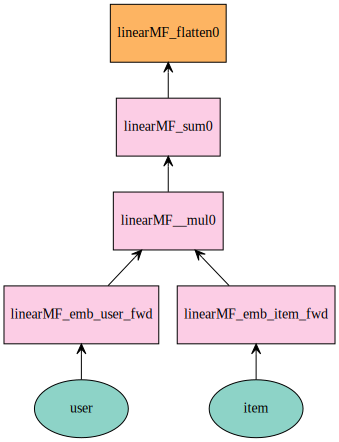

In [12]:
class LinearMatrixFactorization(gluon.HybridBlock):
    
    def __init__(self, k):
        super(LinearMatrixFactorization, self).__init__(prefix='linearMF_')
        
        # user feature lookup
        with self.name_scope():
            self.user_embedding = gluon.nn.Embedding(input_dim=max_user, output_dim = k, prefix='emb_user_') 

            # item feature lookup
            self.item_embedding = gluon.nn.Embedding(input_dim=max_item, output_dim = k, prefix='emb_item_') 
    
    def hybrid_forward(self, F, user, item):
        user_embeddings = self.user_embedding(user)
        items_embeddings = self.item_embedding(item)
        
        # predict by the inner product, which is elementwise product and then sum
        pred = (user_embeddings * items_embeddings).sum(axis=1)
        
        return pred.flatten()

net1 = LinearMatrixFactorization(64)
net1.initialize(mx.init.Xavier(), ctx=ctx)
mx.viz.plot_network(net1(mx.sym.var('user'), mx.sym.var('item')), node_attrs={"fixedsize":"false"})

In [13]:
net1.summary(user.as_in_context(ctx), item.as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                                (50,), (50,)               0
         Embedding-1                                    (50, 64)           60416
         Embedding-2                                    (50, 64)          107712
LinearMatrixFactorization-3                                     (50, 1)               0
Parameters in forward computation graph, duplicate included
   Total params: 168128
   Trainable params: 168128
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique parameters in model: 168128
--------------------------------------------------------------------------------


In [14]:
losses_1 = train(net1, train_data, test_data, epochs=15, optimizer='adam', learning_rate=0.01, ctx=ctx)

Epoch [0], Training RMSE 1.4101, Test RMSE 0.7641
Epoch [1], Training RMSE 0.6431, Test RMSE 0.7035
Epoch [2], Training RMSE 0.5853, Test RMSE 0.6956
Epoch [3], Training RMSE 0.5507, Test RMSE 0.6473


INFO:root:Update[8001]: Change learning rate to 2.00000e-03


Epoch [4], Training RMSE 0.5208, Test RMSE 0.6518
Epoch [5], Training RMSE 0.3329, Test RMSE 0.4964
Epoch [6], Training RMSE 0.2854, Test RMSE 0.4920
Epoch [7], Training RMSE 0.2706, Test RMSE 0.4919
Epoch [8], Training RMSE 0.2578, Test RMSE 0.4956


INFO:root:Update[16001]: Change learning rate to 4.00000e-04


Epoch [9], Training RMSE 0.2493, Test RMSE 0.4920
Epoch [10], Training RMSE 0.1968, Test RMSE 0.4864
Epoch [11], Training RMSE 0.1932, Test RMSE 0.4884
Epoch [12], Training RMSE 0.1921, Test RMSE 0.4900
Epoch [13], Training RMSE 0.1910, Test RMSE 0.4916
Epoch [14], Training RMSE 0.1902, Test RMSE 0.4923


## Neural Network (non-linear) MF
The non-linear model converges strangely with Adam.

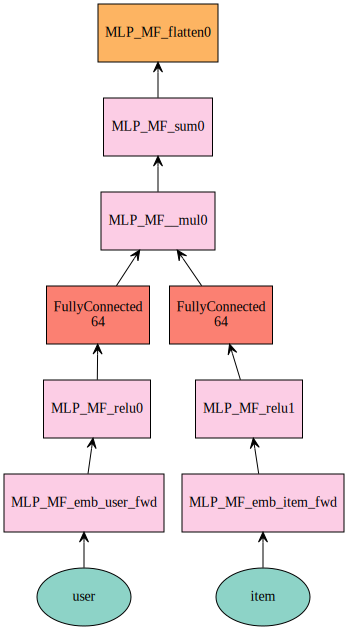

In [15]:
class MLPMatrixFactorization(gluon.HybridBlock):
    
    def __init__(self, k, hidden):
        super(MLPMatrixFactorization, self).__init__(prefix='MLP_MF_')
        
        # user feature lookup
        with self.name_scope():
            self.user_embedding = gluon.nn.Embedding(input_dim=max_user, output_dim = k, prefix='emb_user_') 
            self.user_mlp = gluon.nn.Dense(hidden, prefix='dense_user_')

            # item feature lookup
            self.item_embedding = gluon.nn.Embedding(input_dim=max_item, output_dim = k, prefix='emb_item_') 
            self.item_mlp = gluon.nn.Dense(hidden, prefix='dense_item_')
    
    def hybrid_forward(self, F, user, item):
        user_embeddings = self.user_embedding(user)
        user_embeddings_relu = user_embeddings.relu()
        user_transformed = self.user_mlp(user_embeddings_relu)
        
        items_embeddings = self.item_embedding(item)
        items_embeddings_relu = items_embeddings.relu()
        items_transformed = self.item_mlp(items_embeddings_relu)
        
        # predict by the inner product, which is elementwise product and then sum
        pred = (user_transformed * items_transformed).sum(axis=1)
        
        return pred.flatten()

net2 = MLPMatrixFactorization(64, 64)
net2.initialize(mx.init.Xavier(), ctx=ctx)
mx.viz.plot_network(net2(mx.sym.var('user'), mx.sym.var('item')), node_attrs={"fixedsize":"false"})

In [16]:
net2.summary(user.as_in_context(ctx), item.as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                                (50,), (50,)               0
         Embedding-1                                    (50, 64)           60416
             Dense-2                                    (50, 64)            4160
         Embedding-3                                    (50, 64)          107712
             Dense-4                                    (50, 64)            4160
MLPMatrixFactorization-5                                     (50, 1)               0
Parameters in forward computation graph, duplicate included
   Total params: 176448
   Trainable params: 176448
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique parameters in model: 176448
--------------------------------------------------------------------------------


In [17]:
losses_2  = train(net2, train_data, test_data, epochs=15, optimizer='adam', learning_rate=0.01, ctx=ctx)

Epoch [0], Training RMSE 0.5860, Test RMSE 0.5099
Epoch [1], Training RMSE 0.4848, Test RMSE 0.5096
Epoch [2], Training RMSE 0.4775, Test RMSE 0.5025
Epoch [3], Training RMSE 0.4750, Test RMSE 0.5035


INFO:root:Update[8001]: Change learning rate to 2.00000e-03


Epoch [4], Training RMSE 0.4759, Test RMSE 0.4994
Epoch [5], Training RMSE 0.4305, Test RMSE 0.4559
Epoch [6], Training RMSE 0.4162, Test RMSE 0.4509
Epoch [7], Training RMSE 0.4132, Test RMSE 0.4475
Epoch [8], Training RMSE 0.4120, Test RMSE 0.4498


INFO:root:Update[16001]: Change learning rate to 4.00000e-04


Epoch [9], Training RMSE 0.4110, Test RMSE 0.4438
Epoch [10], Training RMSE 0.3875, Test RMSE 0.4377
Epoch [11], Training RMSE 0.3808, Test RMSE 0.4361
Epoch [12], Training RMSE 0.3772, Test RMSE 0.4362
Epoch [13], Training RMSE 0.3748, Test RMSE 0.4352
Epoch [14], Training RMSE 0.3730, Test RMSE 0.4341


## Deep Neural Network (Residual Network / ResNet)
Borrowing ideas from [Deep Residual Learning for Image Recognition (He, et al.)](https://arxiv.org/abs/1512.03385) to build a complex deep network that is aggressively regularized to avoid over-fitting, but still achieves good performance. 

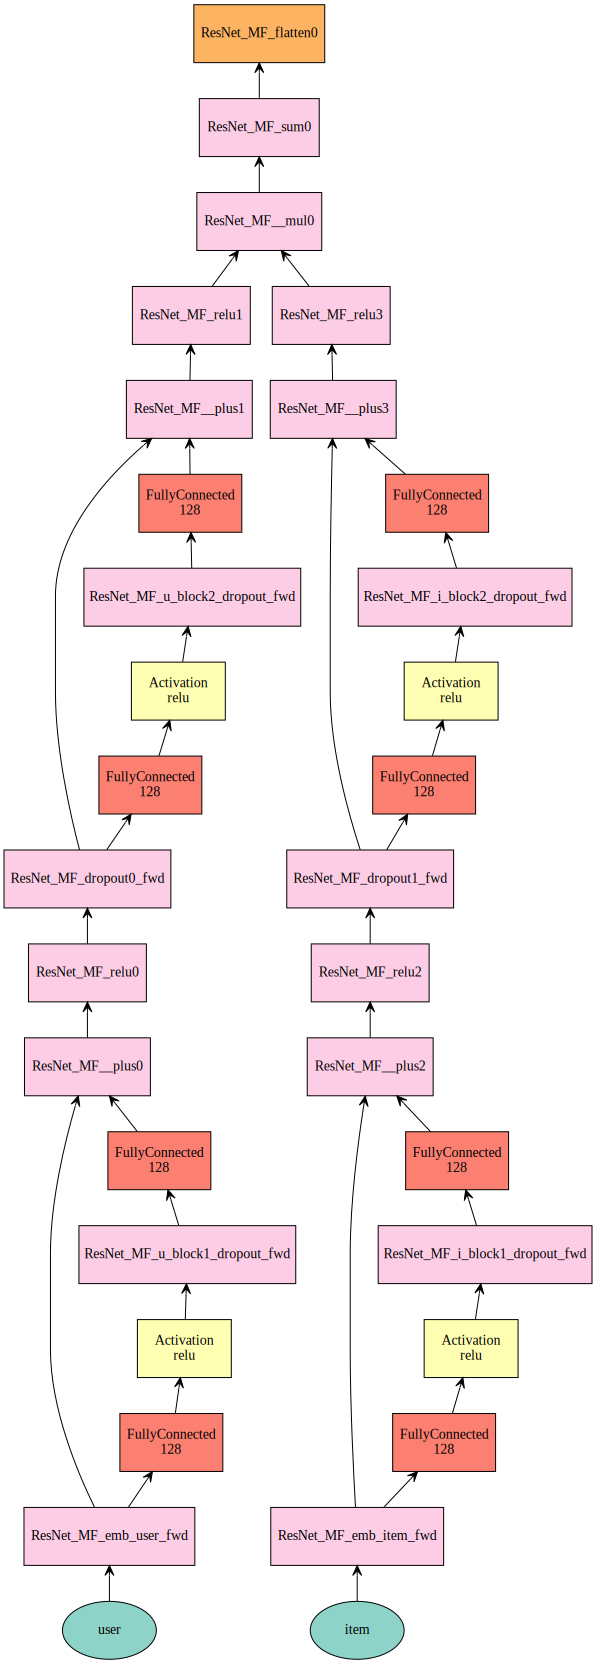

In [39]:
def get_residual_block(prefix='res_block_', hidden=64):
    block = gluon.nn.HybridSequential(prefix=prefix)
    with block.name_scope():
        block.add(
            gluon.nn.Dense(hidden, activation='relu', prefix='d1_'),
            gluon.nn.Dropout(0.5, prefix='dropout_'),
            gluon.nn.Dense(hidden, prefix='d2_')
        )
    return block
    
class ResNetMatrixFactorization(gluon.HybridBlock):
    
    def __init__(self, k, hidden):
        super(ResNetMatrixFactorization, self).__init__(prefix='ResNet_MF_')
        
        # user feature lookup
        with self.name_scope():
            self.user_embedding = gluon.nn.Embedding(input_dim=max_user, output_dim = k, prefix='emb_user_')
            self.user_block1 = get_residual_block('u_block1_', hidden)
            self.user_dropout = gluon.nn.Dropout(0.5)
            self.user_block2 = get_residual_block('u_block2_', hidden)           
            
            # item feature lookup
            self.item_embedding = gluon.nn.Embedding(input_dim=max_item, output_dim = k, prefix='emb_item_')
            self.item_block1 = get_residual_block('i_block1_', hidden)
            self.item_dropout = gluon.nn.Dropout(0.5)
            self.item_block2 = get_residual_block('i_block2_', hidden)           
            
    
    def hybrid_forward(self, F, user, item):
        user_embeddings = self.user_embedding(user)
        user_block1 = self.user_block1(user_embeddings)
        user1 = (user_embeddings + user_block1).relu()
        
        user2 = self.user_dropout(user1)
        user_block2 = self.user_block2(user2)
        user_transformed = (user2 + user_block2).relu()
        
        item_embeddings = self.item_embedding(item)
        item_block1 = self.item_block1(item_embeddings)
        item1 = (item_embeddings + item_block1).relu()
        
        item2 = self.item_dropout(item1)
        item_block2 = self.item_block2(item2)
        item_transformed = (item2 + item_block2).relu()
        
        # predict by the inner product, which is elementwise product and then sum
        pred = (user_transformed * item_transformed).sum(axis=1)
        
        return pred.flatten()

net3 = ResNetMatrixFactorization(128, 128)
net3.initialize(mx.init.Xavier(), ctx=ctx)
mx.viz.plot_network(net3(mx.sym.var('user'), mx.sym.var('item')), node_attrs={"fixedsize":"false"})

In [40]:
net3.summary(user.as_in_context(ctx), item.as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                                (50,), (50,)               0
         Embedding-1                                   (50, 128)          120832
        Activation-2     <Symbol ResNet_MF_u_block1_d1_relu_fwd>               0
        Activation-3                                   (50, 128)               0
             Dense-4                                   (50, 128)           16512
           Dropout-5                                   (50, 128)               0
             Dense-6                                   (50, 128)           16512
           Dropout-7                                   (50, 128)               0
        Activation-8     <Symbol ResNet_MF_u_block2_d1_relu_fwd>               0
        Activation-9                                   (50, 128)               0
            Dense-10        

In [44]:
losses_3  = train(net3, train_data, test_data, epochs=30, optimizer='adam', learning_rate=0.001, ctx=ctx, num_epoch_lr=10)

Epoch [0], Training RMSE 0.4477, Test RMSE 0.4495
Epoch [1], Training RMSE 0.4295, Test RMSE 0.4443
Epoch [2], Training RMSE 0.4250, Test RMSE 0.4419
Epoch [3], Training RMSE 0.4211, Test RMSE 0.4438
Epoch [4], Training RMSE 0.4192, Test RMSE 0.4408
Epoch [5], Training RMSE 0.4184, Test RMSE 0.4413
Epoch [6], Training RMSE 0.4159, Test RMSE 0.4363
Epoch [7], Training RMSE 0.4160, Test RMSE 0.4360
Epoch [8], Training RMSE 0.4146, Test RMSE 0.4347


INFO:root:Update[16001]: Change learning rate to 2.00000e-04


Epoch [9], Training RMSE 0.4131, Test RMSE 0.4340
Epoch [10], Training RMSE 0.3978, Test RMSE 0.4259
Epoch [11], Training RMSE 0.3936, Test RMSE 0.4248
Epoch [12], Training RMSE 0.3904, Test RMSE 0.4243
Epoch [13], Training RMSE 0.3897, Test RMSE 0.4234
Epoch [14], Training RMSE 0.3873, Test RMSE 0.4248
Epoch [15], Training RMSE 0.3871, Test RMSE 0.4228
Epoch [16], Training RMSE 0.3869, Test RMSE 0.4225
Epoch [17], Training RMSE 0.3847, Test RMSE 0.4239
Epoch [18], Training RMSE 0.3840, Test RMSE 0.4225


INFO:root:Update[32001]: Change learning rate to 4.00000e-05


Epoch [19], Training RMSE 0.3848, Test RMSE 0.4229
Epoch [20], Training RMSE 0.3785, Test RMSE 0.4218
Epoch [21], Training RMSE 0.3780, Test RMSE 0.4220
Epoch [22], Training RMSE 0.3777, Test RMSE 0.4215
Epoch [23], Training RMSE 0.3779, Test RMSE 0.4215
Epoch [24], Training RMSE 0.3771, Test RMSE 0.4218
Epoch [25], Training RMSE 0.3761, Test RMSE 0.4216
Epoch [26], Training RMSE 0.3774, Test RMSE 0.4217
Epoch [27], Training RMSE 0.3753, Test RMSE 0.4215
Epoch [28], Training RMSE 0.3748, Test RMSE 0.4216
Epoch [29], Training RMSE 0.3751, Test RMSE 0.4212


## Visualizing results
Compare accuracy and training time across the models.

In [45]:
train_1, test_1 = list(zip(*losses_1))
train_2, test_2 = list(zip(*losses_2))
train_3, test_3 = list(zip(*losses_3))

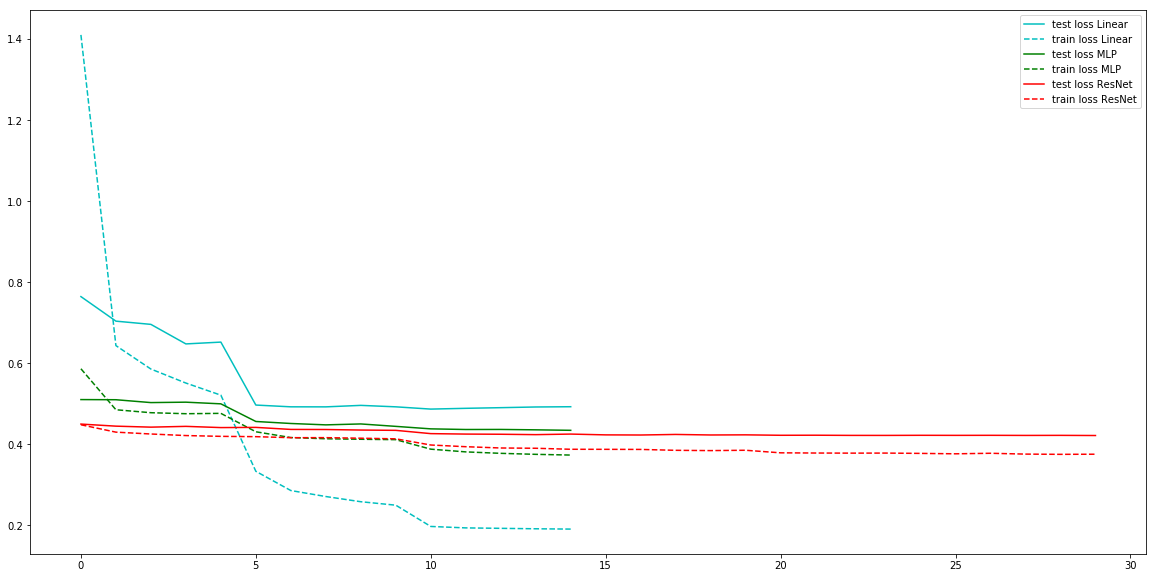

In [46]:
plt.figure(figsize=(20,10))
h1, = plt.plot(range(15), test_1, 'c', label='test loss Linear')
h2, = plt.plot(range(15), train_1, 'c--', label='train loss Linear')
h3, = plt.plot(range(15), test_2, 'g', label='test loss MLP')
h4, = plt.plot(range(15), train_2, 'g--', label='train loss MLP')
h5, = plt.plot(range(30), test_3, 'r', label='test loss ResNet')
h6, = plt.plot(range(30), train_3, 'r--', label='train loss ResNet')
l   = plt.legend(handles=[h1, h2, h3, h4, h5, h6])